# Option-implied PDFs

http://econweb.rutgers.edu/mizrach/pubs/[42]-2010_Handbook.pdf

https://www.mathworks.com/company/newsletters/articles/estimating-option-implied-probability-distributions-for-asset-pricing.html

## Black-Scholes

$$\begin{align}
C &= N(d_1) S - N(d_2) Ke^{-rt} \\
P &= - N(-d_1)S + N(-d_2)Ke^{-rt} 
\end{align}
$$

where 
$$\begin{align}
d_1 &= \frac{1}{\sigma \sqrt{t}}\left[\ln \frac S K + (r + \frac{\sigma^2}{2})t\right] \\
d_2 &=  d_1 - \sigma \sqrt t
\end{align}
$$

We will use a simple Black-Scholes model in order to generate payoff diagrams.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import yfinance as yf

In [2]:
def option_value(option_type, S, K, sigma, t=0, r=0):
    """
    Calculate the value of an option using the Black-Scholes model
    
    :param option_type: "call"/"c" or "put"/"p"
    :type option_type: str
    :param S: price of the underlying
    :type S: float
    :param K: strike price of option
    :type K: float
    :param sigma: input implied volatility
    :type sigma: float
    :param t: time to expiration
    :type t: float, optional
    :param r: risk-free rate
    :type r: float, optional
    """
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    if option_type.lower() in {"c", "call"}:
        return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))
    elif option_type.lower() in {"p", "put"}:
        return -np.multiply(norm.cdf(-d1), S) + np.multiply(norm.cdf(-d2), K * np.exp(-r * t))

In [3]:
# Construction of a butterfly spread
S = np.linspace(50, 150, 1000)
C1 = option_value("c", S, 90, sigma=0.20)
C2 = -option_value("c", S, 100, sigma=0.20)
C3 = option_value("c", S, 110, sigma=0.20)
butterfly = C1 + 2 * C2 + C3

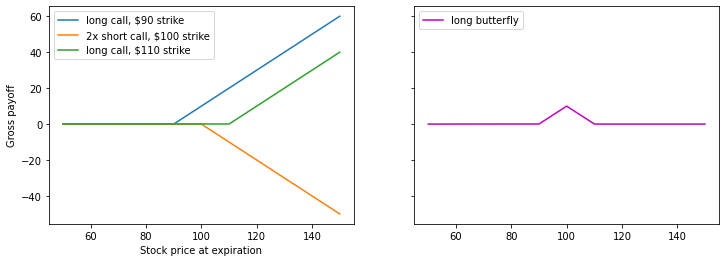

In [4]:
# (Gross) payoff diagram
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax.plot(S, C1, S, C2, S, C3)
ax.set_xlabel("Stock price at expiration")
ax.set_ylabel("Gross payoff")
ax.legend(["long call, $90 strike", "2x short call, $100 strike", "long call, $110 strike"], loc="best")

ax1.plot(S, butterfly, c="m")
ax1.legend(["long butterfly"], loc="upper left")
# plt.show();
plt.savefig("long_butterfly.png", dpi=200)

## Implied distributions from butterfly spreads

Using data from my broker, Firstrade, we will attempt to use the prices of butterfly spreads to infer the risk-neutral probability of a certain move in the underlying.

In [5]:
# Read in call and put data from excel
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0
...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55


In [6]:
puts = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="put")
puts

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest
0,170,0.01,0.0,0.00,0.01,0 x 14192,0,12433
1,175,0.02,0.0,0.00,0.01,0 x 12853,0,1001
2,180,0.01,0.0,0.00,0.01,0 x 13285,0,29
3,185,0.01,0.0,0.00,0.01,0 x 12094,0,3
4,190,0.01,0.0,0.00,0.01,0 x 11473,0,311
...,...,...,...,...,...,...,...,...
110,405,0.00,0.0,70.96,71.29,150 x 150,0,0
111,410,0.00,0.0,75.97,76.28,150 x 150,0,0
112,415,0.00,0.0,80.98,81.27,150 x 150,0,0
113,420,0.00,0.0,85.97,86.27,150 x 150,0,0


In [7]:
# Find midprices from bid/asks
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
puts["midprice"] = (puts.bid + puts.ask)/2
puts = puts[puts.midprice > 0]
calls.tail(30)

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
85,353,0.07,0.00,0.07,0.08,8069 x 12235,0,447,0.075
86,354,0.06,0.00,0.06,0.07,3377 x 15224,0,621,0.065
87,355,0.06,0.01,0.05,0.06,693 x 16589,10,1685,0.055
88,356,0.05,-0.01,0.04,0.05,6205 x 13597,1,133,0.045
89,357,0.05,0.00,0.03,0.04,12642 x 10876,0,217,0.035
90,358,0.05,0.00,0.02,0.03,24527 x 3035,0,931,0.025
91,359,0.03,0.00,0.02,0.03,17058 x 11058,1,166,0.025
92,360,0.02,-0.01,0.02,0.03,3404 x 14911,13,857,0.025
93,361,0.01,-0.01,0.01,0.02,24305 x 4582,6,867,0.015
94,362,0.02,0.00,0.01,0.02,18921 x 11277,0,156,0.015


In [8]:
calls.iloc[70:83].reset_index(drop=True)

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,338,1.99,-0.15,2.01,2.03,138 x 754,77,1718,2.020
1,339,1.69,-0.11,1.66,1.68,185 x 550,121,970,1.670
2,340,1.38,-0.14,1.36,1.37,121 x 1364,426,14048,1.365
3,341,1.08,-0.21,1.09,1.11,250 x 1089,37,2455,1.100
4,342,0.87,-0.14,0.87,0.88,250 x 131,191,11182,0.875
5,343,0.74,-0.07,0.69,0.70,119 x 3308,103,10889,0.695
6,344,0.55,-0.08,0.54,0.55,171 x 3441,56,1694,0.545
7,345,0.44,-0.06,0.42,0.43,277 x 2330,52,2292,0.425
8,346,0.34,-0.07,0.32,0.33,5831 x 310,69,721,0.325
9,347,0.28,-0.03,0.25,0.26,6338 x 1368,11,922,0.255


In [9]:
puts.head(10)

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.01,0.0,0.0,0.01,0 x 14192,0,12433,0.005
1,175,0.02,0.0,0.0,0.01,0 x 12853,0,1001,0.005
2,180,0.01,0.0,0.0,0.01,0 x 13285,0,29,0.005
3,185,0.01,0.0,0.0,0.01,0 x 12094,0,3,0.005
4,190,0.01,0.0,0.0,0.01,0 x 11473,0,311,0.005
5,195,0.01,0.0,0.0,0.01,0 x 11527,0,302,0.005
6,200,0.01,0.0,0.0,0.01,0 x 10963,0,446,0.005
7,205,0.02,0.0,0.0,0.01,0 x 7905,0,332,0.005
8,210,0.01,0.0,0.0,0.01,0 x 8400,0,27,0.005
9,215,0.02,0.0,0.0,0.01,0 x 10678,0,103,0.005


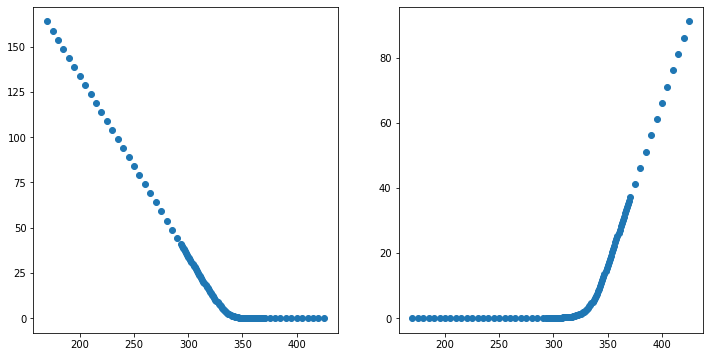

In [10]:
# Visualise put and call prices
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.scatter(calls.strike, calls.midprice);
ax1.scatter(puts.strike, puts.midprice);
plt.show()

In [11]:
# Construct butterflies
data = []

for (_, left) ,(_,centre), (_, right) in zip(calls.iterrows(), calls.iloc[1:].iterrows(), calls.iloc[2:].iterrows()):
    # Filter out all zero volume
    if not any(vol > 0 for vol in {left.volume, centre.volume, right.volume}):
        continue
    # Filter out any zero open interest
    if not all(oi > 0 for oi in {left.openInterest, centre.openInterest, right.openInterest}):
        continue
    # Equidistant on either end
    if centre.strike - left.strike != right.strike - centre.strike:
        continue
    butterfly_price = left.midprice - 2* centre.midprice + right.midprice
    max_profit = centre.strike - left.strike
    data.append([centre.strike, butterfly_price, max_profit])

bflys = pd.DataFrame(data, columns=["strike", "price", "max_profit"])
bflys["prob"] = bflys.price / bflys.max_profit
bflys

,strike,price,max_profit,prob
0,322,1.000000e-02,1,1.000000e-02
1,323,1.500000e-02,1,1.500000e-02
2,324,1.500000e-02,1,1.500000e-02
3,325,3.000000e-02,1,3.000000e-02
4,326,1.500000e-02,1,1.500000e-02
5,327,2.500000e-02,1,2.500000e-02
6,328,2.500000e-02,1,2.500000e-02
7,329,3.000000e-02,1,3.000000e-02
8,330,3.500000e-02,1,3.500000e-02
9,331,3.000000e-02,1,3.000000e-02


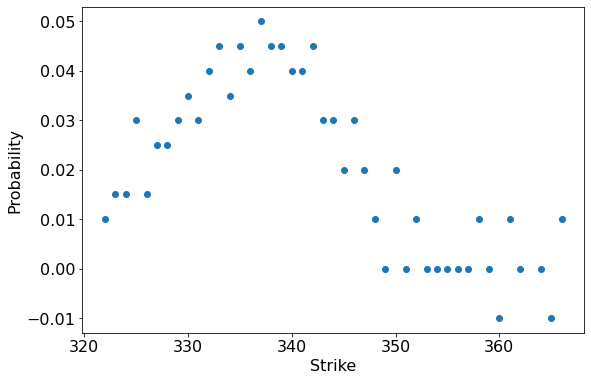

In [12]:
# SPY was trading around 335 when this data was collected
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9,6))
plt.scatter(bflys.strike, bflys.prob);
plt.xlabel("Strike")
plt.ylabel("Probability")
plt.show()
# plt.savefig("SPY_raw_bfly_prob.png", dpi=300)

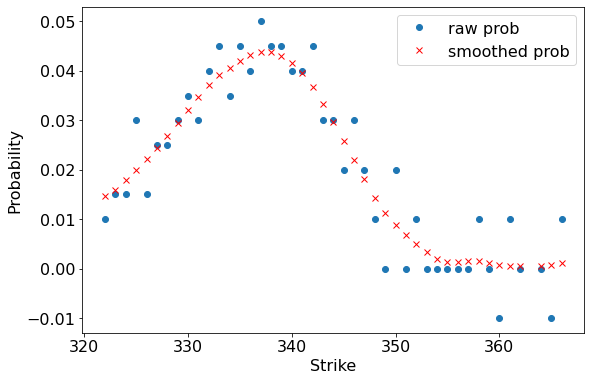

In [13]:
from scipy.ndimage import gaussian_filter1d

smoothed_prob = gaussian_filter1d(bflys.prob, 2)

plt.figure(figsize=(9,6))
plt.plot(bflys.strike, bflys.prob, "o", bflys.strike, smoothed_prob, "rx")
plt.legend(["raw prob", "smoothed prob"], loc="best")
plt.xlabel("Strike")
plt.ylabel("Probability")
plt.show()
# plt.savefig("SPY_smooth_bfly_prob.png", dpi=300)

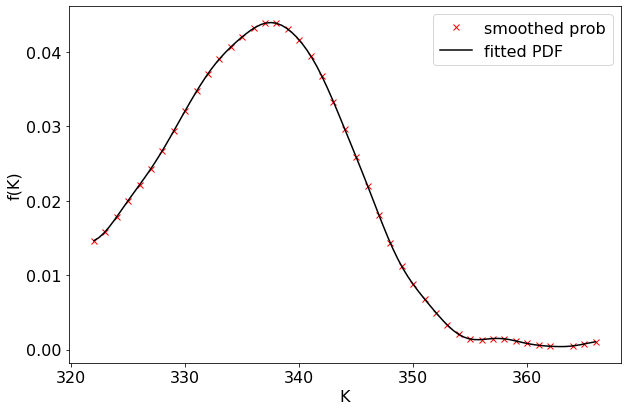

In [14]:
plt.figure(figsize=(9,6))
pdf = scipy.interpolate.interp1d(bflys.strike, smoothed_prob, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.linspace(bflys.strike.min(), bflys.strike.max(), 100)
plt.plot(bflys.strike, smoothed_prob, "rx", x_new, pdf(x_new), "k-");
plt.legend(["smoothed prob", "fitted PDF"], loc="best")
plt.xlabel("K")
plt.ylabel("f(K)")
plt.tight_layout()
plt.show()
# plt.savefig("SPY_bfly_pdf.png", dpi=300)

In [15]:
# Find area under curve
raw_total_prob = scipy.integrate.trapz(smoothed_prob, bflys.strike)
print(f"Raw total probability: {raw_total_prob}")

# Don't need to normalise because there is mass in the left tail that we are ignoring

# # Normalise
# normalised_prob = smoothed_prob / raw_total_prob
# total_prob = scipy.integrate.trapz(normalised_prob, bflys.strike)
# print(f"Normalised total probability: {total_prob}")
# # should be less than 1

Raw total probability: 0.872620109383161


### Put butterflies

We can repeat the process with put butterflies instead of call butterflies.

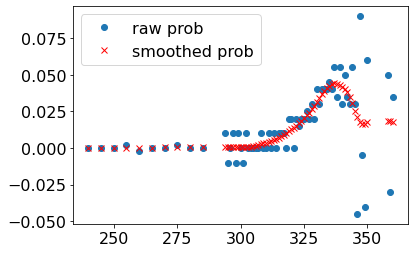

In [16]:
# Repeating the same with put butterflies
from scipy.ndimage import gaussian_filter1d

data = []

for (_, left) ,(_,centre), (_, right) in zip(puts.iterrows(), puts.iloc[1:].iterrows(), puts.iloc[2:].iterrows()):
    # Filter out all zero volume
    if not any(vol > 0 for vol in {left.volume, centre.volume, right.volume}):
        continue
    # Filter out any zero open interest
    if not all(oi > 0 for oi in {left.openInterest, centre.openInterest, right.openInterest}):
        continue
    # Equidistant on either end
    if centre.strike - left.strike != right.strike - centre.strike:
        continue
    butterfly_price = left.midprice - 2* centre.midprice + right.midprice
    max_profit = centre.strike - left.strike
    data.append([centre.strike, butterfly_price, max_profit])

put_bflys = pd.DataFrame(data, columns=["strike", "price", "max_profit"])
put_bflys["prob"] = put_bflys.price / put_bflys.max_profit
smoothed_prob_put = gaussian_filter1d(put_bflys.prob, 2)
plt.plot(put_bflys.strike, put_bflys.prob, "o", put_bflys.strike, smoothed_prob_put, "rx")
plt.legend(["raw prob", "smoothed prob"], loc="best")
plt.show()

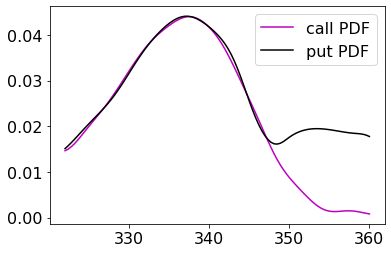

In [17]:
put_pdf = scipy.interpolate.interp1d(put_bflys.strike, smoothed_prob_put, kind="cubic", 
                                     fill_value=0.0)
x_new = np.linspace(bflys.strike.min(), put_bflys.strike.max(), 100)
plt.plot(x_new, pdf(x_new), "m-", x_new, put_pdf(x_new), "k-");
plt.legend(["call PDF", "put PDF"], loc="best")
plt.show()

### Refactor butterfly PDF code

In [18]:
def construct_pdf(calls_df, make_plot=True, fill_value="extrapolate"):
    if "midprice" not in calls_df.columns:
        calls_df["midprice"] = (calls_df.bid + calls_df.ask) /2
    
    # Construct butterflies
    data = []

    for (_, left) ,(_,centre), (_, right) in zip(calls_df.iterrows(), calls_df.iloc[1:].iterrows(), calls_df.iloc[2:].iterrows()):
        # Filter out all zero volume
        if not any(vol > 0 for vol in {left.volume, centre.volume, right.volume}):
            continue
        # Filter out any zero open interest
        if not all(oi > 0 for oi in {left.openInterest, centre.openInterest, right.openInterest}):
            continue
        # Equidistant on either end
        if centre.strike - left.strike != right.strike - centre.strike:
            continue
        butterfly_price = left.midprice - 2* centre.midprice + right.midprice
        max_profit = centre.strike - left.strike
        data.append([centre.strike, butterfly_price, max_profit])

    bflys = pd.DataFrame(data, columns=["strike", "price", "max_profit"])
    bflys["prob"] = bflys.price / bflys.max_profit

    smoothed_prob = gaussian_filter1d(bflys.prob, 2)
    pdf = scipy.interpolate.interp1d(bflys.strike, smoothed_prob, kind="cubic",
                                     fill_value=fill_value)
    if not make_plot:
        return pdf
    
    plt.figure(figsize=(9,6))
    x_new = np.linspace(bflys.strike.min(), bflys.strike.max(), 100)
    plt.plot(bflys.strike, smoothed_prob, "rx", x_new, pdf(x_new), "k-");
    plt.legend(["smoothed prob", "fitted PDF"], loc="best")
    plt.xlabel("K")
    plt.ylabel("f(K)")



## Implied PDF from Breeden-Litzenberger

$$ \frac{\partial^2 C}{\partial K^2} = e^{r\tau} \frac{\partial^2 C}{\partial K^2} $$

So we need to interpolate. The choice is between price space and volatility space.

In [19]:
calls = pd.read_excel("SPY_191020exp_290920.xlsx", sheet_name="call")
calls["midprice"] = (calls.bid + calls.ask)/2
calls = calls[calls.midprice > 0]
calls

,strike,lastPrice,change,bid,ask,BxA,volume,openInterest,midprice
0,170,0.00,0.0,163.70,164.06,146 x 146,0,0,163.880
1,175,0.00,0.0,158.70,159.06,146 x 146,0,0,158.880
2,180,0.00,0.0,153.69,154.05,146 x 102,0,0,153.870
3,185,0.00,0.0,148.70,149.04,146 x 102,0,0,148.870
4,190,0.00,0.0,143.70,144.06,146 x 146,0,0,143.880
...,...,...,...,...,...,...,...,...,...
110,405,0.01,0.0,0.00,0.01,0 x 11065,0,28,0.005
111,410,0.02,0.0,0.00,0.01,0 x 8620,0,200,0.005
112,415,0.01,0.0,0.00,0.01,0 x 8630,0,5,0.005
113,420,0.02,0.0,0.00,0.01,0 x 8641,0,55,0.005


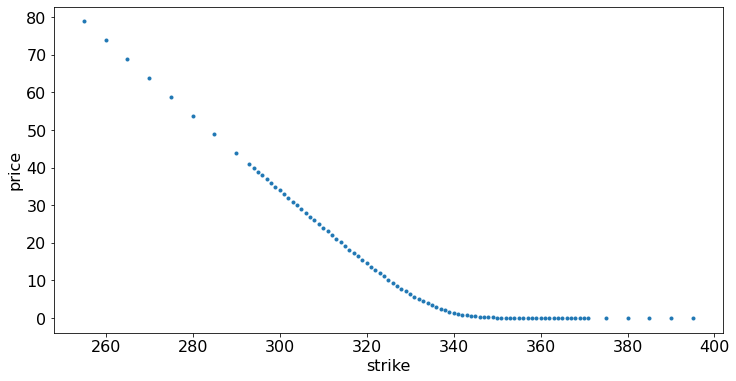

In [20]:
calls_sub = calls[(calls.strike > 250) & (calls.strike < 400)]
plt.figure(figsize=(12,6))
plt.plot(calls_sub.strike, calls_sub.midprice, ".");
plt.xlabel("strike")
plt.ylabel("price")
plt.savefig("call_prices.png", dpi=400)
plt.show()

### B-S IV

B-S doesn't have a closed-form inverse, which means to find the IV from the price we must resort to numerical methods. This in itself can be quite a deep topic, but we are going to be simplistic in our approach and just use Newton's method. To do, we need a function that computes the call price from inputs (already written above), and a function to evaluate the gradient of the call price function with respect to the volatility parameter - this is known as **vega**. 

In [21]:
def call_value(S, K, sigma, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=0.2, max_iter=1000, verbose=False):
    iv = initial_guess
    for _ in range(max_iter):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    return iv 

In [22]:
c_test = call_value(100, 110, 0.2, t=1)
print(c_test)

4.292010941409885


In [23]:
# Check that it works
bs_iv(c_test, 100,110, t=1)

0.2

In [24]:
S = 332
t = 3/52
calls["iv"] = calls.apply(lambda row: bs_iv(row.midprice, S, row.strike, t, max_iter=500), axis=1)

<ipython-input-21-08b1dc83cea8>:21: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
<ipython-input-21-08b1dc83cea8>:4: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
<ipython-input-21-08b1dc83cea8>:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [25]:
def plot_vol_smile(calls, savefig=False):
    plt.figure(figsize=(9,6))
    plt.plot(calls.strike, calls.iv, ".")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    if savefig:
        plt.savefig("vol_smile.png",dpi=300)
    plt.show()

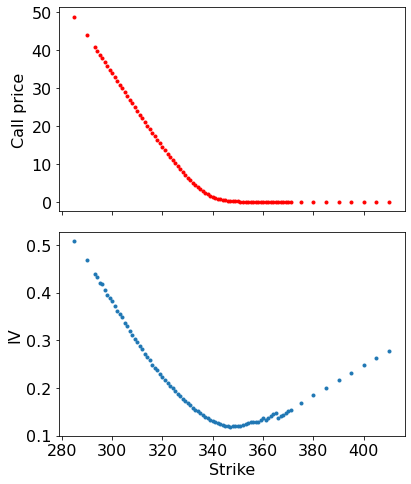

In [26]:
calls_no_na = calls.dropna()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
ax1.plot(calls_no_na.strike, calls_no_na.midprice, "r.")
ax1.set_ylabel("Call price")
ax2.plot(calls_no_na.strike, calls_no_na.iv, ".")
ax2.set_ylabel("IV")
ax2.set_xlabel("Strike")
plt.tight_layout()
# plt.savefig("calls_to_iv.png", dpi=400)
plt.show()

In [27]:
calls_clean = calls.dropna().copy()
calls_clean["iv"] = gaussian_filter1d(calls_clean.iv, 3)

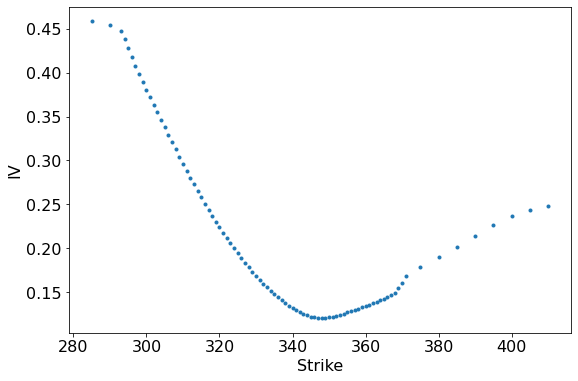

In [28]:
plot_vol_smile(calls_clean)

In [29]:
calls_clean = calls_clean[(calls_clean.strike > 300) & (calls_clean.strike < 375)]

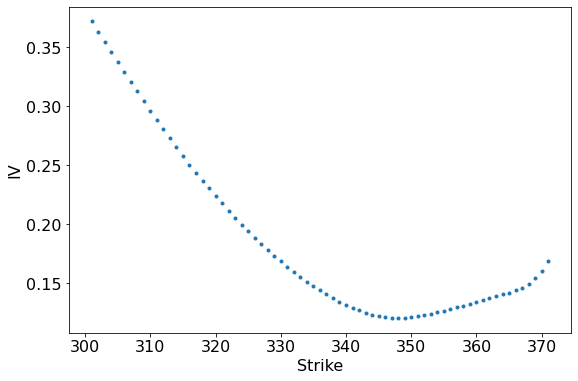

In [30]:
plot_vol_smile(calls_clean, savefig=False)

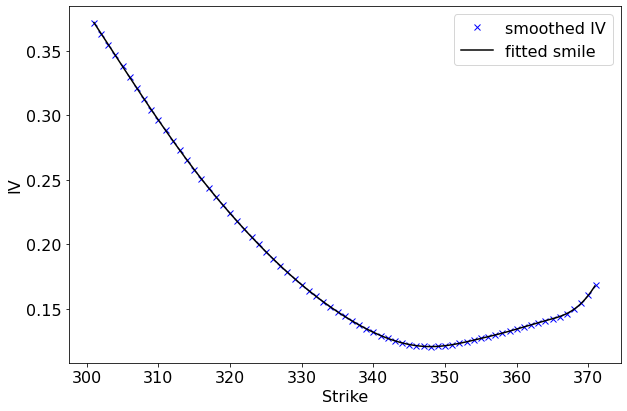

In [31]:
plt.figure(figsize=(9,6))
vol_surface = scipy.interpolate.interp1d(calls_clean.strike, calls_clean.iv, kind="cubic",
                                 fill_value="extrapolate")
x_new = np.arange(calls_clean.strike.min(), calls_clean.strike.max(), 0.1)
plt.plot(calls_clean.strike, calls_clean.iv, "bx", x_new, vol_surface(x_new), "k-");
plt.legend(["smoothed IV", "fitted smile"], loc="best")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.tight_layout()
# plt.savefig("SPY_smile.png", dpi=300)
plt.show()

In [32]:
C_interp = call_value(S, x_new, vol_surface(x_new), t)

In [33]:
first_deriv = np.gradient(C_interp, x_new)
second_deriv = np.gradient(first_deriv, x_new)

In [34]:
def pdf2(Krange, S, t=0, r=0):
    # x is a range of strikes
    Crange = call_value(S, Krange, vol_surface(Krange), t, r)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return np.exp(r * t) * second_deriv

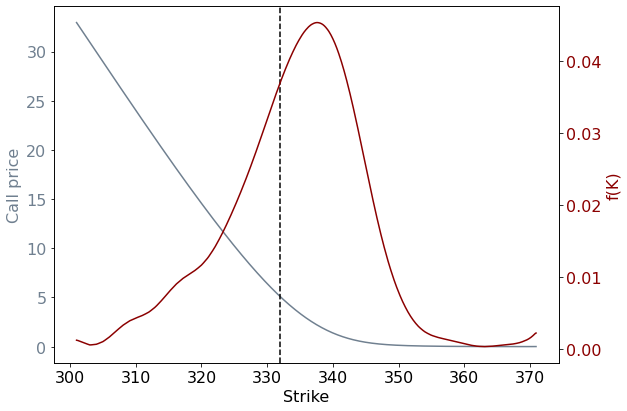

In [35]:
fig, ax1 = plt.subplots(figsize=(9,6))

col="slategrey"
ax1.set_xlabel('Strike')
ax1.set_ylabel('Call price', color=col)
ax1.plot(x_new, C_interp, color=col)
ax1.tick_params(axis='y', labelcolor=col)
ax1.axvline(332, color="k", linestyle="--")

ax2 = ax1.twinx()
col = 'darkred'
ax2.set_ylabel('f(K)', color=col)
ax2.plot(x_new, pdf2(x_new, S, t), color=col)
ax2.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()

In [36]:
data = np.vstack([x_new, pdf(x_new), pdf2(x_new, S, t)]).T
data = data[(data[:, 0] < 360) & (data[:, 0] > 320)]
k, bfly_pdf, curve_pdf = np.hsplit(data,3)

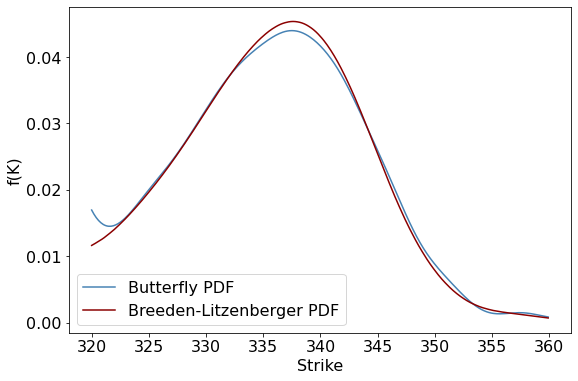

In [37]:
plt.figure(figsize=(9,6))
plt.plot(k, bfly_pdf, "steelblue", k, curve_pdf, "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Butterfly PDF", "Breeden-Litzenberger PDF"], loc="best")
# plt.savefig("butterfly_vs_breeden.png", dpi=300)
plt.show()

Note that the Breeden-Liztenberger PDF is much more well-behaved OTM (doesn't have the same kinks between 355-360).

Also, we have a lot more data (butterflies each require 3 prices), which is why we can extend the strikes further out as per the previous diagram – though note that even Breeden-Litzenberger starts to behave nonsensically.

BUt we have one other thing to compare it to: Breeden-Liztenberger applied directly to the interpolated calls (without interpolating in IV space).

In [38]:
calls["price_clean"] = gaussian_filter1d(calls.midprice, 3)
price_interp = scipy.interpolate.interp1d(calls.strike, calls.price_clean, kind="cubic",
                                 fill_value="extrapolate")
C_interp_direct = price_interp(x_new)

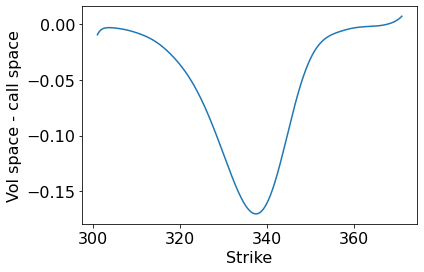

In [39]:
plt.plot(x_new, C_interp - C_interp_direct)
plt.xlabel("Strike")
plt.ylabel("Vol space - call space")
plt.show()

In [40]:
def pdf3(calls, Krange, S, t=0, r=0):
    # x is a range of strikes
    calls["price_clean"] = gaussian_filter1d(calls.midprice, 3)
    price_interp = scipy.interpolate.interp1d(calls.strike, calls.price_clean, kind="cubic",
                                     fill_value="extrapolate")
    Crange = price_interp(Krange)
    first_deriv = np.gradient(Crange, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    return second_deriv

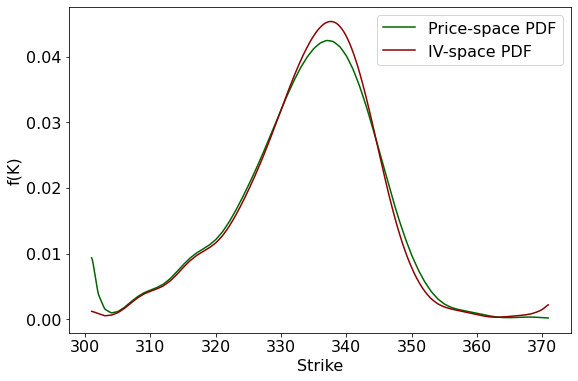

In [41]:
plt.figure(figsize=(9,6))
plt.plot(x_new, pdf3(calls, x_new, S, t), "darkgreen", x_new, pdf2(x_new, S, t), "darkred")
plt.xlabel("Strike")
plt.ylabel("f(K)")
plt.legend(["Price-space PDF", "IV-space PDF"], loc="best")
# plt.savefig("price_vol_comparison.png", dpi=300)
plt.show()

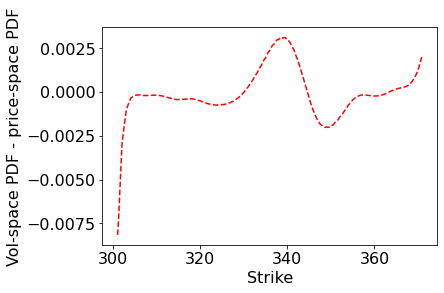

In [42]:
plt.plot(x_new, pdf2(x_new, S, t) - pdf3(calls, x_new, S, t), "r--");
plt.xlabel("Strike")
plt.ylabel("Vol-space PDF - price-space PDF")
plt.show()